In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import sin, cos, pi, log, exp, log10

import csv

In [2]:
def integrate_Simpson(f, dx, a, b):
  s = 0
  x = a
  while (x<b):
    s += (f(x) + 4*f(x+dx/2) + f(x + dx)) * dx/6
    x += dx
  return s

In [3]:
deg = pi/180
rad = 180/pi

# Частота в Гц, длина волны в метрах
f0 = 3*10**9
lmbd0 = 3*10**8 / f0
k = 2*pi / lmbd0

theta_max = pi/2 # максимальный угол отклонения

# Параметры решётки
Nx = 16
Ny = 1

# dx = 0.5 * lmbd0
# dy = 0.5 * lmbd0
dx = lmbd0 / (1 + abs(sin(theta_max)))
dy = 0.5 * lmbd0

# Размер апертуры
Lx = (Nx - 1) * dx
Ly = (Ny - 1) * dy

# Координаты излучателей в линейке
xx = np.arange(0, Nx) * dx - Lx/2
yy = np.arange(0, Ny) * dy - Ly/2


/tmp/ipykernel_25067/1859533405.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  F[i] += DN_ones(theta[i]) * AFR[j] * exp(- 1j * k * x[j] * sin(theta[i]))


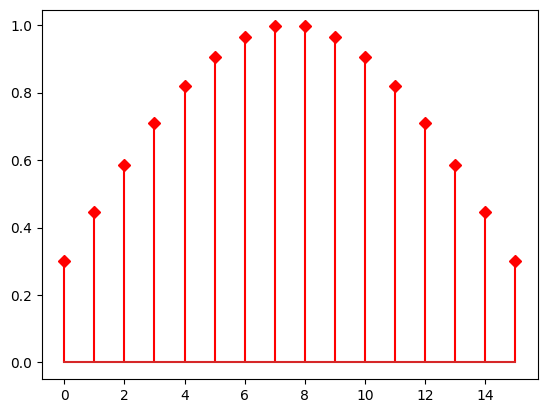

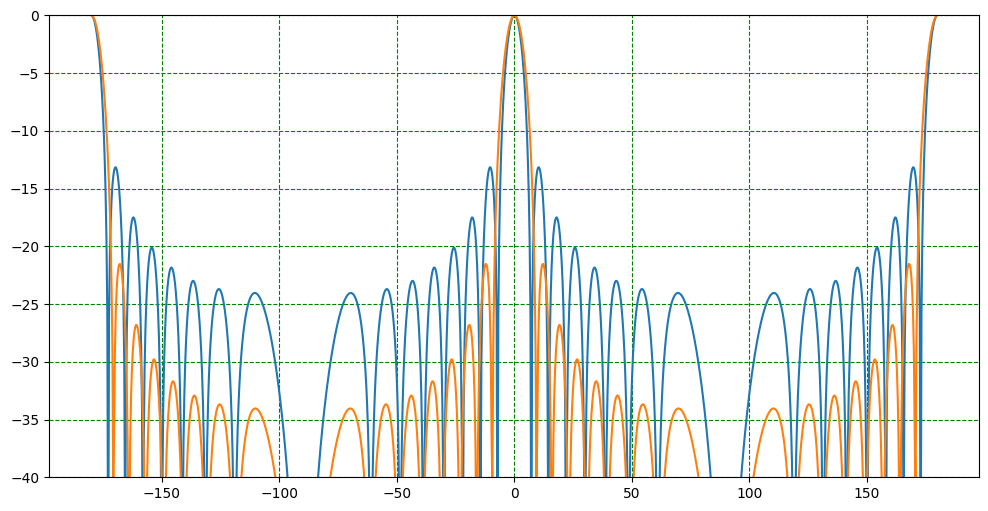

In [4]:
Theta = np.arange(-pi, pi, pi/500)
Phi = np.arange(-pi, pi, pi/500)

# Амплитудное распределение
def AFR_ones(x):
    return np.ones(len(x))

def AFR_cos(x, delta = 0.3):
    return delta + (1 - delta) * cos(pi * x/Lx)

AFR = AFR_ones(xx)
AFR_cos = AFR_cos(xx)
plt.stem(AFR_cos, linefmt='red', markerfmt='D')

def DN_ones(theta):
    return 1


def DN_0(x, theta, AFR):
    theta_count = len(theta)
    F = np.zeros(theta_count)
    for i in range(theta_count):
        for j in range(len(x)):
            F[i] += DN_ones(theta[i]) * AFR[j] * exp(- 1j * k * x[j] * sin(theta[i]))
    return F/np.max(F)

FF = 20*log10(abs(DN_0(xx, Theta, AFR)))
FF_cosdelta = 20*log10(abs(DN_0(xx, Theta, AFR_cos)))
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(Theta*180/pi, FF)
ax.plot(Theta*180/pi, FF_cosdelta)
ax.set_ylim(ymin=-40, ymax=0)
ax.grid(linestyle='--', color='green')

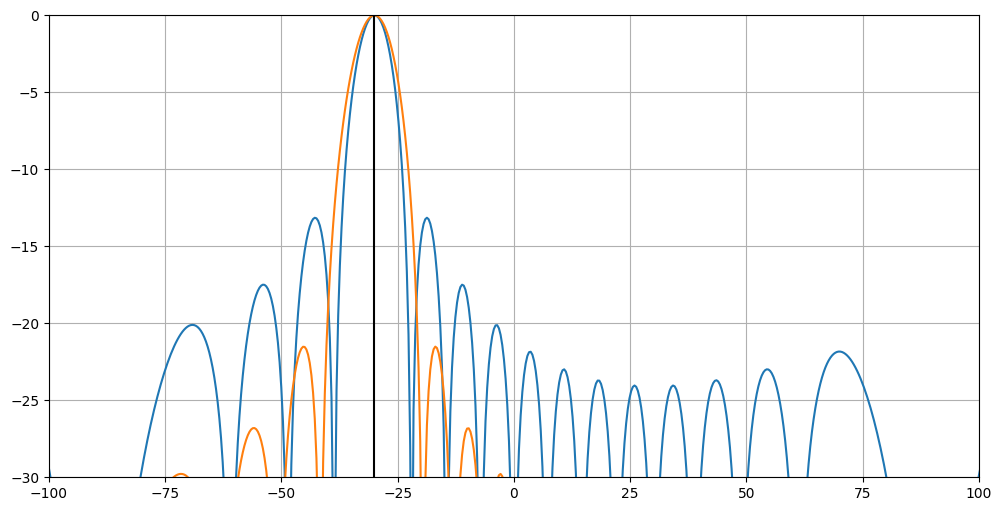

In [5]:
def DN(x, theta, AFR, theta_otkl = 0):
    theta_count = len(theta)
    F = np.zeros(theta_count, dtype = 'complex_')
    for i in range(theta_count):
        for j in range(len(x)):
            F[i] += DN_ones(theta[i]) * AFR[j] * exp(- 1j * k * x[j] * (sin(theta[i]) - sin(theta_otkl)))
    return F/sum(np.abs(AFR))


theta_otkl = -30*deg

FF = 20*log10(abs(DN(xx, Theta, AFR, theta_otkl)))
FF_cosdelta = 20*log10(abs(DN(xx, Theta, AFR_cos, theta_otkl)))

fig, ax = plt.subplots(figsize = (12,6))
# plt.style.use('ggplot')
ax.plot(Theta*180/pi, FF)
ax.plot(Theta*180/pi, FF_cosdelta)
ax.set_ylim(ymin=-30, ymax=0)
ax.set_xlim(xmin=-100, xmax=100)
ax.vlines(theta_otkl/deg, ymin=-30, ymax=0, colors='black')
ax.grid()

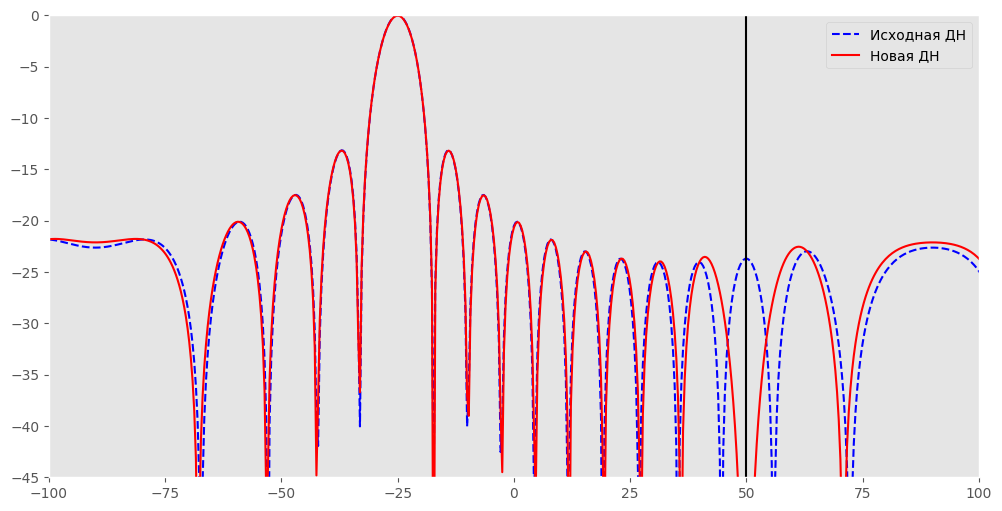

In [15]:
def DN_pomeh(x, theta, AFR, theta_pomehi = 30, theta_otkl = 0):
    theta_count = len(theta)
    F_0 = DN(x, theta, AFR, theta_otkl)
    F_pomehi = DN(x, theta, AFR, theta_pomehi) * DN(x, [theta_pomehi], AFR, theta_otkl)
    return F_0 - F_pomehi

theta_otkl = -25*deg        # угол отклонения луча
theta_pomehi = 50*deg   # угол направления помехи
FF = 20*log10(abs(DN(xx, Theta, AFR, theta_otkl)))     # Исходная ДН
FF_pom = 20*log10(abs(DN_pomeh(xx, Theta, AFR, theta_pomehi, theta_otkl))) # ДН с подавленным направлением помехи


fig, ax = plt.subplots(figsize = (12,6))
ax.plot(Theta*180/pi, FF, 'b', linestyle= '--', label='Исходная ДН')
ax.plot(Theta*180/pi, FF_pom, 'red', label='Новая ДН')
ax.set_ylim(ymin=-45, ymax=0)
ax.set_xlim(xmin=-100, xmax=100)
ax.vlines(theta_pomehi/deg, ymin=-45, ymax=0, colors='black')
ax.legend()
ax.grid()

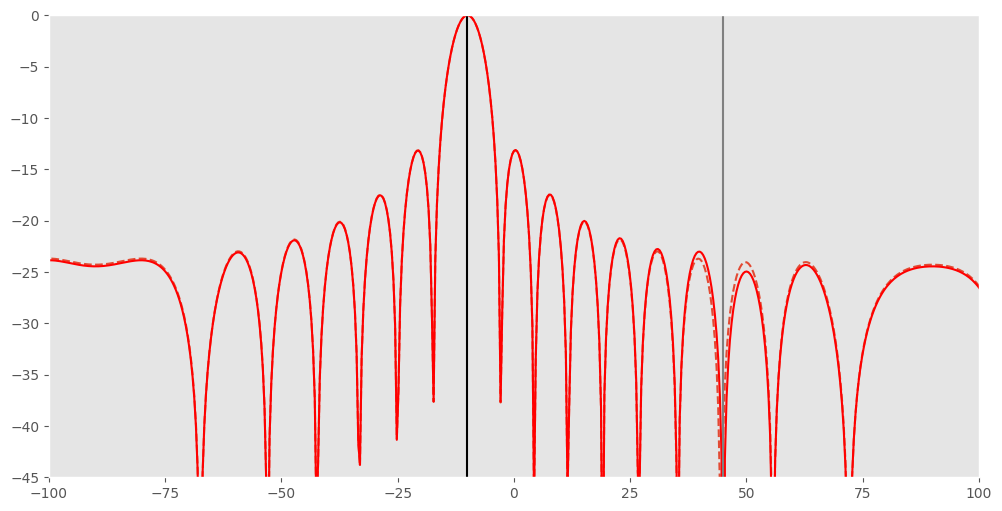

In [ ]:
def AFR_pomeh(x, AFR, theta_pomehi, theta_otkl = 0):
    koef = DN(x, [theta_pomehi], AFR, theta_otkl)
    AFR_new = AFR * ( 1 * exp(1j * k * x * sin(theta_otkl)) - koef * exp(1j * k * x * sin(theta_pomehi) ) ) 
    return AFR_new
    

theta_otkl = -10*deg        # угол отклонения луча
theta_pomehi = 45*deg   # угол направления помехи

AFR_pom = AFR_pomeh(xx, AFR, theta_pomehi, theta_otkl)
# print(AFR_pom)

FF_0 = 20*log10(abs(DN(xx, Theta, AFR, theta_otkl)))     # Исходная ДН
FF_pom = 20*log10(abs(DN(xx, Theta, AFR_pom)))     # ДН с новым АФР. Новое АФР учитывает отклонение луча!!! Не передавать ещё раз theta_otkl

fig, ax = plt.subplots(figsize = (12,6))
ax.plot(Theta*180/pi, FF_0, '--')
ax.plot(Theta*180/pi, FF_pom, 'red')
ax.set_ylim(ymin=-45, ymax=0)
ax.set_xlim(xmin=-100, xmax=100)
ax.vlines(theta_pomehi/deg, ymin=-45, ymax=0, colors='grey')
ax.vlines(theta_otkl/deg, ymin=-45, ymax=0, colors='black')
ax.grid()

In [ ]:
def SaveAFR(x, AFR):
    with open("AFR.csv", mode="w", encoding='utf-8') as w_file:
        file_writer = csv.writer(w_file, delimiter = ",", lineterminator="\r")
        file_writer.writerow(['Coordinate', 'AFR'])
        for i in range(len(x)):
            file_writer.writerow([x[i], AFR[i]])

SaveAFR(xx, AFR_pom)

Text(0.5, 0.92, 'DN')

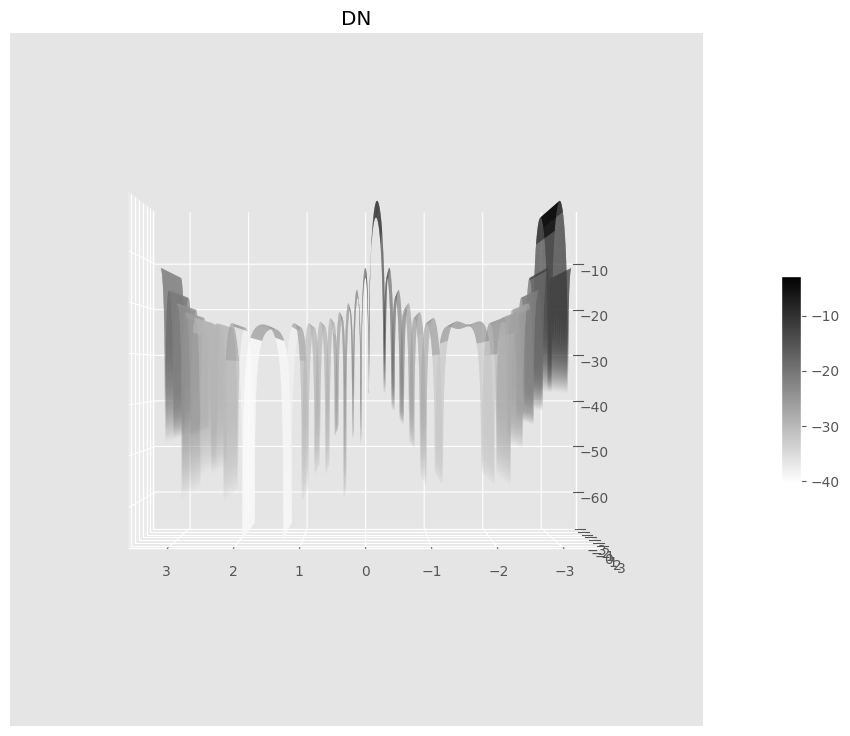

In [ ]:
th = np.outer(Theta, np.ones(len(Theta)))
ph = np.outer(Phi, np.ones(len(Phi))).T

F0 = np.outer(FF_0, np.ones(len(FF_0)))


fig = plt.figure(figsize =(20, 9))
ax = plt.axes(projection ='3d')
my_cmap = plt.get_cmap('binary')

surf = ax.plot_surface(th, ph, F0,
                cmap = my_cmap,
                edgecolor ='none')
ax.view_init(elev=0, azim=90)
fig.colorbar(surf, ax = ax,
             shrink = 0.3, aspect = 10)
 
ax.set_title('DN')

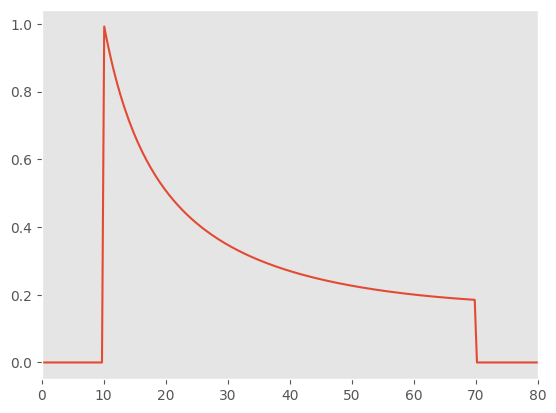

In [ ]:
theta1 = 10*deg
theta2 = 70*deg

def cosec(theta):
    return 1/sin(theta)

def F_Cosec(theta, theta1, theta2):
    return np.array(list(map(lambda t:cosec(t)/cosec(theta1) if (t>=theta1 and t<=theta2) else 0, theta)))

# F_Cosec(Theta, theta1, theta2)
plt.plot(Theta*rad, F_Cosec(Theta, theta1, theta2))
plt.xlim(0, 80)
plt.grid()